# Image Classification ile Mama Kabındaki Yabancı Cisimlerin Tespiti

Bağlı bulunan kamera tarafından akıllı mama kabının üstünden veya yanından çekilmiş fotoğraflarda mama kabının içerisinde mama veya yabancı cisim olup olmadığının tespit edilmesini sağlayan derin öğrenme modelinin geliştirilmesi

Gerekli kütüphanelerin import edilmesiyle başlayalım

In [281]:
import pandas as pd
import numpy as np
import random
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# 1. Veri Setini Tanıyalım

Elimizde Arduinoya bağlı bir kamera olmadığı için internet üzerinden boş veya mama dolu olan mama kaplarının fotoğraflarını aldık. Yabancı cisimler için hayvan besleyen arkadaşlarımızdan da yardım alarak kendi setimizi oluşturduk.

In [282]:
# Normal ve Anormal fotoğrafların bulunduğu klasörleri alalım
normal_path = os.getcwd() + "/images/normal/"
abnormal_path = os.getcwd() + "/images/abnormal/"

# Dosya isimlerini alalım
normal_images_names = os.listdir(normal_path)
abnormal_images_names = os.listdir(abnormal_path)

# Dictionary içerisinde görselleri ve etiketleri tutalım
# 0 - Normal Durum
# 1 - Anormal Durum

dictionary = {"Image": [], "Label":[]}

for image_name in normal_images_names:
    img=image.load_img(normal_path + image_name, target_size=(32,32,1), grayscale=True)
    img = image.img_to_array(img)
    #img = img/255
    dictionary["Image"].append(img)
    dictionary["Label"].append(0)
        
        
for image_name in abnormal_images_names:
    img=image.load_img(abnormal_path + image_name, target_size=(32,32,1), grayscale=True)
    img = image.img_to_array(img)
    #img = img/255
    dictionary["Image"].append(img)
    dictionary["Label"].append(1)

# Pandas DataFrame oluşturalım
data = pd.DataFrame.from_dict(dictionary)


C:\Users\bhasfe\AppData\Roaming\Python\Python37\site-packages\keras_preprocessing\image\utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\bhasfe\anaconda3\envs\tensorflow\lib\site-packages\PIL\Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Veri setimizi oluşturduk. Kısaca gözatalım

In [283]:
# Verisetindeki ilk 10 kolonu gösterelim
display(data.head(10))

# Info
print(data.info())

# Özet istatistiklere bakalım
display(data.describe())

,Image,Label
0,"[[[255.0], [255.0], [255.0], [255.0], [255.0],...",0
1,"[[[255.0], [255.0], [255.0], [255.0], [255.0],...",0
2,"[[[255.0], [255.0], [255.0], [255.0], [255.0],...",0
3,"[[[255.0], [255.0], [255.0], [255.0], [255.0],...",0
4,"[[[255.0], [255.0], [255.0], [255.0], [255.0],...",0
5,"[[[255.0], [255.0], [255.0], [255.0], [255.0],...",0
6,"[[[255.0], [255.0], [255.0], [255.0], [255.0],...",0
7,"[[[255.0], [255.0], [255.0], [255.0], [255.0],...",0
8,"[[[125.0], [115.0], [98.0], [125.0], [162.0], ...",0
9,"[[[255.0], [255.0], [255.0], [255.0], [255.0],...",0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   137 non-null    object
 1   Label   137 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.3+ KB
None


,Label
count,137.000000
mean,0.175182
std,0.381518
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Elimizde hangi etiketten kaçta olduğuna bakalım

Label
0    113
1     24
dtype: int64


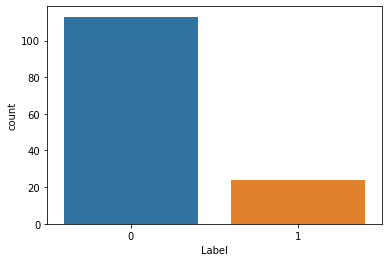

In [284]:
# Etiket sayılarını bastıralım
print(data.value_counts("Label"))

# Etiket sayılarını görselleştirelim
sns.countplot(data=data, x="Label")

Bazı görsellere göz atalım

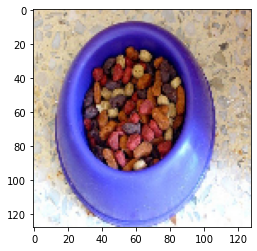

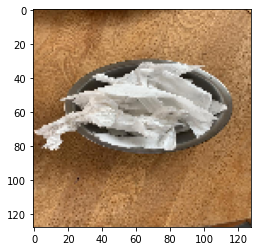

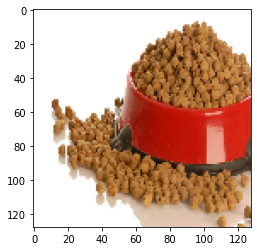

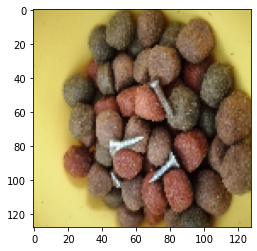

In [287]:
def show_pictures(label):
    
    if label == "normal":
        path = os.getcwd() + "/images/normal/"
    elif label == "abnormal":
        path = os.getcwd() + "/images/abnormal/"
    else:
        print("Invalid Label")
        
    random_img = random.choice(os.listdir(path))
    img_path = os.path.join(path, random_img)

    img = image.load_img(img_path, target_size=(128, 128))
    img_tensor = image.img_to_array(img)
    img_tensor /= 255.
    plt.imshow(img_tensor)
    plt.show()
    
for i in range(0,2):
    show_pictures("normal")
    show_pictures("abnormal")

# 2. Modeli Oluşturalım ve Eğitelim

Öncelikle elimizdeki veri setini Train ve Test(Validation) setleri olarak ayıralım. Elimizdeki veri sınırlı sayıda olduğu için üç ayrı sete bölmeyeceğiz.

In [288]:
# Bağımlı ve bağımsız değişkenlerimizi seçelim
X = np.array(dictionary["Image"])
y = np.array(dictionary["Label"])

# Eğitim ve Test(Validation) verisi olarak verimizi bölelim
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=34,test_size=0.3,stratify=y)

Modelimizi Oluşturmaya başlayalım

In [289]:
# Modeli Oluşturalım
model = Sequential()
model.add(Conv2D(5, kernel_size=3, activation='relu',input_shape=(32,32,1),padding="same"))
model.add(Conv2D(15, kernel_size=3, activation='relu',padding="same"))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# Compile edelim
model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

# Model özetini bastıralım
model.summary()

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_91 (Conv2D)           (None, 32, 32, 5)         50        
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 32, 32, 15)        690       
_________________________________________________________________
flatten_39 (Flatten)         (None, 15360)             0         
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 15361     
Total params: 16,101
Trainable params: 16,101
Non-trainable params: 0
_________________________________________________________________


Artık modelimizi eğitebiliriz

In [290]:
history=model.fit(X_train, y_train, epochs=20)

Epoch 1/20
95/95 [==============================] - 0s 1ms/step - loss: 15.3184 - accuracy: 0.7368
Epoch 2/20
95/95 [==============================] - 0s 148us/step - loss: 12.7700 - accuracy: 0.8211
Epoch 3/20
95/95 [==============================] - 0s 158us/step - loss: 7.2139 - accuracy: 0.6316
Epoch 4/20
95/95 [==============================] - 0s 147us/step - loss: 3.1386 - accuracy: 0.6526
Epoch 5/20
95/95 [==============================] - 0s 147us/step - loss: 5.3379 - accuracy: 0.8211
Epoch 6/20
95/95 [==============================] - 0s 200us/step - loss: 5.1708 - accuracy: 0.8211
Epoch 7/20
95/95 [==============================] - 0s 158us/step - loss: 2.4077 - accuracy: 0.8421
Epoch 8/20
95/95 [==============================] - 0s 158us/step - loss: 0.1990 - accuracy: 0.9789
Epoch 9/20
95/95 [==============================] - 0s 148us/step - loss: 0.6751 - accuracy: 0.9158
Epoch 10/20
95/95 [==============================] - 0s 147us/step - loss: 0.5224 - accuracy: 0.8947

Başarımızı test edelim

In [306]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("Test Accuracy:"+": %.2f%%" % (scores[1]*100))

42/42 [==============================] - 0s 143us/step
Test Accuracy:: 85.71%


Accuracy ve Loss grafiklerine bakalım

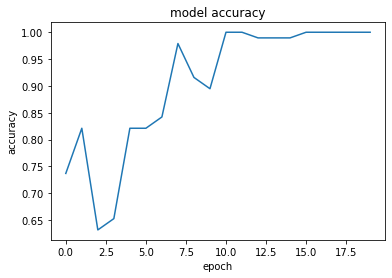

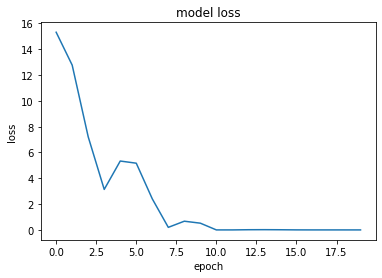

In [292]:
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

#  "LOSS"
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

Modeli sunucuda kullanmak üzere kaydedelim

In [293]:
# Modeli kaydedelim
with open("isfood_model.json", "w") as json_file: 
    json_file.write(model.to_json())
    
# Model ağırlıklarını kaydedelim
model.save_weights("is_foodweights.h5")